## How to call immune subtypes on new data ##

Let's suppose you have some:
  a.) RPKM (or FPKM or something equivlent) gene expression data 
  b.) Has hg19 gene symbols mapped to it.
  c.) knowledge on how to batch correct / normalize it with regard to TCGA PanCancer data*
  
and you'd like to call some immune subtypes on those samples.

In [38]:

library(ggplot2)
options(repr.plot.width=4, repr.plot.height=3)

In [39]:
#loading TCGA PanCancer EB++ expression data, subset to the pertinent genes.

load('../shiny-app/Immune-Subtype-Clustering/data/ebpp_subset.rda')
dim(datSubset)
datSubset[1:4,1:5]

[1]  2316 11069

,TCGA-OR-A5J1-01A-11R-A29S-07,TCGA-OR-A5J2-01A-11R-A29S-07,TCGA-OR-A5J3-01A-11R-A29S-07,TCGA-OR-A5J5-01A-11R-A29S-07,TCGA-OR-A5J6-01A-31R-A29S-07
A1CF,0.0000,0.000,0.5925,1.5492,0.000
ABCA1,319.4040,1071.800,896.4600,310.6120,800.283
ABCA8,4.3228,121.997,1368.6900,982.1840,5000.650
ABCB11,0.4803,0.000,1.7775,0.0000,0.000


In [40]:
# need to subset before transforms
reportedScores <- read.table('../shiny-app/Immune-Subtype-Clustering//data//five_signature_mclust_ensemble_results.tsv.gz', sep='\t', header=T, stringsAsFactors = F)
head(reportedScores)

AliquotBarcode,SampleBarcode,ClusterModel1,ClusterModel2,LIexpression_score,CSF1_response,TGFB_score_21050467,Module3_IFN_score,CHANG_CORE_SERUM_RESPONSE_UP
TCGA.02.0047.01A.01R.1849.01,TCGA-02-0047-01A,4,4,-1.3536972,0.8995777,0.09838865,-0.43775189,-0.5989618
TCGA.02.0055.01A.01R.1849.01,TCGA-02-0055-01A,4,4,-0.5016848,1.4674281,1.41870736,0.03473346,0.6990816
TCGA.02.2483.01A.01R.1849.01,TCGA-02-2483-01A,4,4,-0.9197809,0.4884155,-0.50393689,-0.68551726,1.0855086
TCGA.02.2485.01A.01R.1849.01,TCGA-02-2485-01A,4,4,-0.7810493,0.1039455,-0.65700848,1.49949319,0.4496605
TCGA.02.2486.01A.01R.1849.01,TCGA-02-2486-01A,4,4,-0.0361280,1.8245642,-0.27930992,2.53785832,0.1475449
TCGA.04.1348.01A.01R.1565.13,TCGA-04-1348-01A,2,2,0.6439911,0.7957605,-0.63769666,0.90119552,1.8003985


In [41]:
# fix the TCGA barcodes # 
library(stringr)
x <- str_replace_all(reportedScores$AliquotBarcode, pattern='\\.', replacement='-')
reportedScores$AliquotBarcodeDashes <- x
rownames(reportedScores) <- reportedScores$AliquotBarcodeDashes


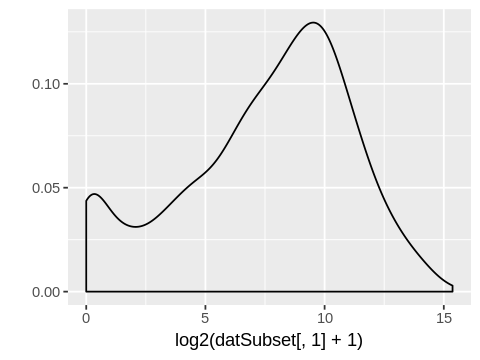

In [42]:
# subset the data before normalizing them
datSubset <- datSubset[,colnames(datSubset) %in% x]

qplot(log2(datSubset[,1]+1), geom='density')

[1] 20130     6

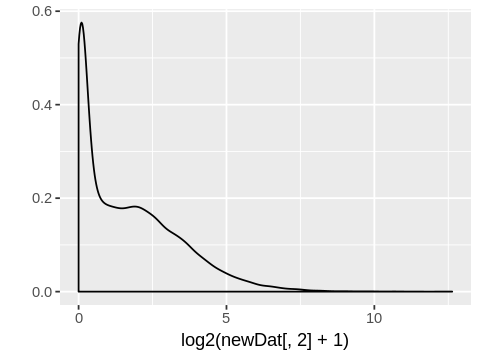

In [43]:
# bring in the new data #
# found some RPKM RNA-seq data
# 
load('../ExtraData/newDat.rda')

dim(newDat)

qplot(log2(newDat[,2]+1), geom='density')

In [44]:
# then let's get all the genes we need for the 5 signatures
load('../shiny-app/Immune-Subtype-Clustering/data/comparative_immuneSigs_geneLists4.rda')

In [45]:

# just to check the gene content of each data set #

sigNames <- c('LIexpression_score','CSF1_response','TGFB_score_21050467','Module3_IFN_score','CHANG_CORE_SERUM_RESPONSE_UP')
genesWeNeed <- c()

for (si in sigs1_2_eg2) {
    if (si$src %in% sigNames) {
        genesWeNeed <- c(genesWeNeed, si$probes)
    }
}

head(genesWeNeed)
length(genesWeNeed)

sharedGenes <- intersect(rownames(datSubset), rownames(newDat))
length(sharedGenes)

sharedGenes <- intersect(genesWeNeed, rownames(newDat))
length(sharedGenes)

# missing some genes. #

[1] "CCL5" "CD19" "CD37" "CD3D" "CD3E" "CD3G"

[1] 446

[1] 2227

[1] 417

### Now, we join the new data with TCGA data ... there should be some aspect of batch correction and/or normalization.

In [46]:

# join the data sources

sharedGenes <- intersect(rownames(datSubset), rownames(newDat))

datSubset2 <- cbind(datSubset[sharedGenes,], newDat[sharedGenes,])

dim(datSubset2)

[1] 2227 9135

In [47]:

# apply the transforms #
# first the log2
datSubsetTransformed <- apply(datSubset2, 2, function(a) log2(a+1))

dim(datSubsetTransformed)
                              
# then the median scale
datSubsetTransformed <- t(apply(datSubsetTransformed, 1, function(a) a - median(a, na.rm=T)))
                              
dim(datSubsetTransformed)

                            

[1] 2227 9135

[1] 2227 9135

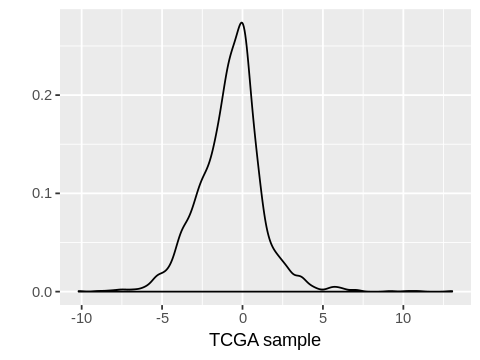

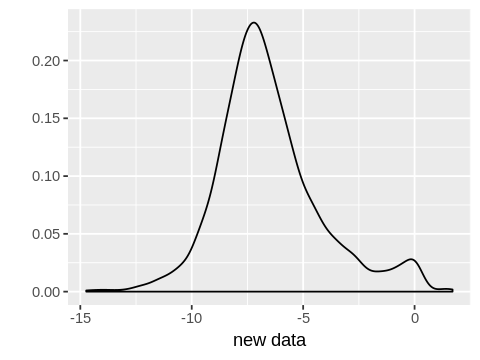

In [48]:
library(ggplot2)
options(repr.plot.width=4, repr.plot.height=3)

qplot(datSubsetTransformed[,1], geom='density', xlab='TCGA sample')
qplot(datSubsetTransformed[,9133], geom='density', xlab='new data')



In [49]:

# and we use the scoring code to produce scores #

source('../Scripts/ImmuneSigs68_function.R')
scores <- ImmuneSigs_function(datSubsetTransformed, 
                              sigs1_2_eg2,
                              sigs12_weighted_means,
                              sigs12_module_weights,
                              sigs1_2_names2,
                              sigs1_2_type2)


[1] "DONE MEAN"
[1] "DONE MEDIAN"
[1] "DONE WEIGHTED MEAN"
[1] "DONE MODULES"
GP11_Immune_IFN 
[1] "DONE ZHANG"
[1] "DONE KEGG"
[1] "DONE CD8 RATIO"
[1] "DONE TAMsurr"
[1] "DONE CHANG CORE"
CSR_Activated_15701700 
[1] "DONE CSR"
B_cell_PCA_16704732 
CD8_PCA_16704732 
GRANS_PCA_16704732 
LYMPHS_PCA_16704732 
T_cell_PCA_16704732 
TGFB_PCA_17349583 
Rotterdam_ERneg_PCA_15721472 
HER2_Immune_PCA_18006808 
[1] "DONE PCA"
[1] "DONE DONE"


In [50]:
scores[1:5,c(1,2,3,9134,9135)]

,TCGA-OR-A5J1-01A-11R-A29S-07,TCGA-OR-A5J2-01A-11R-A29S-07,TCGA-OR-A5J3-01A-11R-A29S-07,rpkm.exp_005_shTRPS1_seq2,rpkm.exp_005_shTRPS1_seq3
ICS5_score,-3.0239,-2.1914,-1.4008,-4.8444,-4.9020
LIexpression_score,-2.0096,-1.6626,-3.0884,-6.1574,-6.1652
Chemokine12_score,-4.0751,-2.2761,-4.5604,-6.9282,-6.9418
NHI_5gene_score,-3.5295,-3.4377,-3.1605,-7.8366,-7.7367
CD68,-2.0480,-1.5651,-1.9824,-10.2040,-10.0477


In [52]:
# in the scripts we did batch correction

source('../Scripts/signature_mclust_ensemble.R')

# and load the models trained on TCGA data #
load('../shiny-app/Immune-Subtype-Clustering/data/wolf_set_slim1.rda')

zscore.cols2<-function(x){
    return((apply(x, 2, function(x) (x - median(na.omit(x)))/sd(na.omit(x)))))
}

                  
# and we subset the 5 scores used in clustering
idx <- c("LIexpression_score", "CSF1_response", "TGFB_score_21050467", "Module3_IFN_score", "CHANG_CORE_SERUM_RESPONSE_UP")
scores <- t(scores[idx,])
zscores <- zscore.cols2(scores)

calls <- consensusEnsemble(mods2, zscores)


Loading required package: clue
Iteration: 0 *** value: 8039.57


In [53]:
# Then we can take the cluster with top probability #

maxcalls <- apply(calls$.Data, 1, function(a) which(a == max(a))[1])
names(maxcalls) <- rownames(scores)


### At this point, the maxcalls, the cluster labels on each sample, are essentially random. 
We need to take the additional step of aligning them with the reported clusters.

In [54]:
# get the overlap between reported clusters and new called clusters

sharedIDs <- intersect(reportedScores$AliquotBarcodeDashes, rownames(scores))

t1 <-table(Reported=as.numeric(reportedScores[sharedIDs, 'ClusterModel1']),
           NewCalls=as.numeric(maxcalls[sharedIDs]))


t1
as.numeric(t1[1,])

        NewCalls
Reported    1    2    3    4    5    6
       1   26    0   26 2289   48   27
       2   12    0    8    6 2561    5
       3   16    1    5   23    3 2349
       4 1058    3    3   28   16   51
       5   11  365    0    0    0    9
       6    7    0  135    5    8   25

[1]   26    0   26 2289   48   27

We need to make column swaps until the diagonal is maximized.

In [55]:
# we'll use a greedy method for now.
# this should work OK, because the largest 
# clusters were the first few anyway

reported <- 1:6
optcalls <- 1:6

for (i in reported) {
    
    # for subtype i, where did most of the samples end up?
    j <- which(as.numeric(t1[i,]) == max(as.numeric(t1[i,])))
    # rename maxcall j <- i
    optcalls[i] <- j
}

print("aligned cluster labels")
optcalls

print('reordered table')
t1[,optcalls]



[1] "aligned cluster labels"


[1] 4 5 6 1 2 3

[1] "reordered table"


        NewCalls
Reported    4    5    6    1    2    3
       1 2289   48   27   26    0   26
       2    6 2561    5   12    0    8
       3   23    3 2349   16    1    5
       4   28   16   51 1058    3    3
       5    0    0    9   11  365    0
       6    5    8   25    7    0  135

### Now we can apply the new cluster labels to all samples, including the new-data-samples.

In [56]:

results <- cbind(calls$.Data, MaxCalls=maxcalls, AlignedCalls=optcalls[maxcalls])

head(results)

,,,,,,,MaxCalls,AlignedCalls
TCGA-OR-A5J1-01A-11R-A29S-07,0.7500000,0.06640625,0.15234375,0.00781250,0.00390625,0.01953125,1,4
TCGA-OR-A5J2-01A-11R-A29S-07,0.0000000,0.01562500,0.01953125,0.00390625,0.00000000,0.96093750,6,3
TCGA-OR-A5J3-01A-11R-A29S-07,0.3476562,0.02734375,0.16406250,0.01953125,0.00000000,0.44140625,6,3
TCGA-OR-A5J5-01A-11R-A29S-07,0.7578125,0.03125000,0.17968750,0.01953125,0.00781250,0.00390625,1,4
TCGA-OR-A5J6-01A-31R-A29S-07,0.6328125,0.10937500,0.06250000,0.00390625,0.00000000,0.19140625,1,4
TCGA-OR-A5J7-01A-11R-A29S-07,0.7890625,0.00000000,0.18750000,0.01171875,0.01171875,0.00000000,1,4


*Where* did those new samples end up?  The expression profiles looked strange. They were probably not the best choice.


In [57]:
results[9130:9135,]

,,,,,,,MaxCalls,AlignedCalls
rpkm.exp_005_shNTC_rep1,0.8007812,0.0078125,0.1562500,0.0234375,0.01171875,0,1,4
rpkm.exp_005_shNTC_rep2,0.8007812,0.0078125,0.1562500,0.0234375,0.01171875,0,1,4
rpkm.exp_005_shNTC_rep3,0.8007812,0.0078125,0.1562500,0.0234375,0.01171875,0,1,4
rpkm.exp_005_shTRPS1_seq1,0.7968750,0.0078125,0.1601562,0.0234375,0.01171875,0,1,4
rpkm.exp_005_shTRPS1_seq2,0.7968750,0.0078125,0.1601562,0.0234375,0.01171875,0,1,4
rpkm.exp_005_shTRPS1_seq3,0.7968750,0.0078125,0.1601562,0.0234375,0.01171875,0,1,4
